In [70]:
import rasterio as rio
from rasterio.plot import plotting_extent
from glob import glob
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
import matplotlib.colors
from itertools import cycle, islice
import pandas as pd
import geopandas as gpd
import re
from skimage.io import imread
from simpledbf import Dbf5
from janitor import clean_names
import datetime
import ee
import pyproj
import requests
import pickle

In [2]:
bands = ["B4", "B3", "B2"]

In [60]:
# Read leaks data

# FTC
ftc_20_raw = clean_names(Dbf5("../data/raw/2020_FTC-EJ.dbf").to_dataframe())
ftc_21_raw = clean_names(Dbf5("../data/raw/2021_FTC-EJ.dbf").to_dataframe())
ftc_22_raw = clean_names(Dbf5("../data/raw/FTC_2022_EJ.dbf").to_dataframe())

# FTA
fta_20_raw = clean_names(Dbf5("../data/raw/2020_FTA-EJ.dbf").to_dataframe()) 
fta_21_raw = clean_names(Dbf5("../data/raw/2021_FTA-EJ.dbf").to_dataframe())
fta_22_raw = clean_names(Dbf5("../data/raw/FTA_2022_EJ.dbf").to_dataframe()) 


In [61]:
# Clean dfs
clean_df = lambda df: df.drop(["codunidad", "nombreesta", "nombretrab", "fecha_de_c", "com1"], axis = 1)
ftc_20 = clean_df(ftc_20_raw)
ftc_21 = clean_df(ftc_21_raw)
ftc_22 = clean_df(ftc_22_raw)

fta_20 = fta_20_raw.drop(["codunidad", "nombreesta", "nombretrab", "fecha_de_c"], axis = 1)
fta_21 = clean_df(fta_21_raw)
fta_22 = clean_df(fta_22_raw)


In [62]:
print("FTC")
print("Total leaks FTC 2020:", ftc_20.shape)
print("Total leaks FTC 2021:", ftc_21.shape)
print("Total leaks FTC 2022:", ftc_22.shape)
print("="*100)

print("FTA")
print("Total leaks FTA 2020:", fta_20.shape)
print("Total leaks FTA 2021:", fta_21.shape)
print("Total leaks FTA 2022:", fta_22.shape)

FTC
Total leaks FTC 2020: (595, 20)
Total leaks FTC 2021: (373, 20)
Total leaks FTC 2022: (267, 20)
FTA
Total leaks FTA 2020: (9784, 20)
Total leaks FTA 2021: (10172, 20)
Total leaks FTA 2022: (10064, 20)


In [63]:
## Merge FTC and FTC

ftc_df = pd.concat([ftc_20, ftc_21, ftc_22])
ftc_df["tipo"] = "FTC"
fta_df = pd.concat([fta_20, fta_21, fta_22])
fta_df["tipo"] = "FTA"

print("FTA leaks: ", fta_df.shape[0])
print("FTC leaks: ", ftc_df.shape[0])

# Full df
leaks = pd.concat([fta_df, ftc_df], ignore_index = True)
leaks.rename(columns = {"x":"X", "y":"Y"}, inplace = True)

# Add year column
leaks["fecha_legal"] = pd.to_datetime(leaks["fechalegal"])
leaks["year"] = leaks["fecha_legal"].dt.year

print("Full leaks df: ", leaks.shape)

FTA leaks:  30020
FTC leaks:  1235
Full leaks df:  (31255, 23)


## EDA 

### Leaks detected totals 

In [64]:
leaks_detected = leaks.groupby("year")["tipo"].value_counts().reset_index(name = "detectadas")

In [65]:
leaks_totals = leaks.groupby("year")["tipo"].value_counts()

In [66]:
leaks.groupby("year")["tipo"].value_counts(normalize = True).mul(100)
leaks_perc = leaks.groupby("year")["tipo"].value_counts(normalize = True).mul(100)

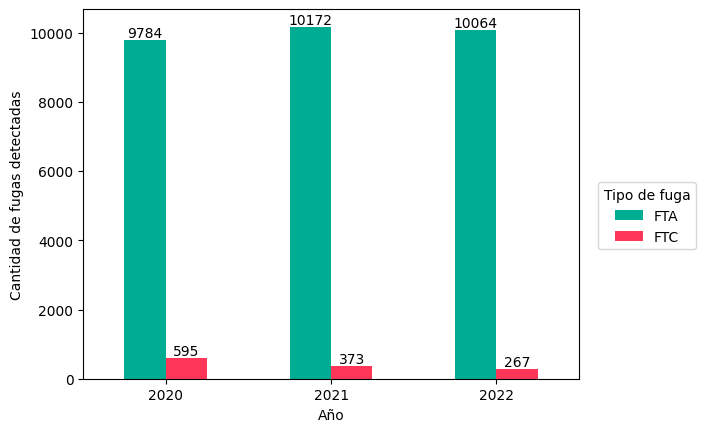

In [68]:
my_colors = list(islice(cycle(["#00ac92", "#ff3657"]), None, 2))

ax = leaks_totals.unstack(fill_value = 0).plot.bar(color = my_colors)
plt.xlabel("Año")
plt.xticks(rotation = 0)
plt.ylabel("Cantidad de fugas detectadas")
plt.legend(title = "Tipo de fuga", bbox_to_anchor = (1.25, 0.55))

for container in ax.containers:
    ax.bar_label(container)

### Leaks repaired totals

In [209]:
leaks_repaired = leaks.query("causal == 'SE REPARA FTC, GENERA BA' | causal == 'EJECUTADA, SE GENERA BA'")

In [210]:
leaks_repaired_summary = leaks_repaired.groupby("year")["tipo"].value_counts().reset_index(name = "reparadas")

In [ ]:
# Get full df of detected and repaired
leaks_detected_repaired = leaks_detected
leaks_detected_repaired["reparadas"] = leaks_repaired_summary["reparadas"]
leaks_detected_repaired

year tipo  detectadas  reparadas
0  2020  FTA        9784       6181
1  2020  FTC         595        472
2  2021  FTA       10172       7681
3  2021  FTC         373        306
4  2022  FTA       10064       7863
5  2022  FTC         267        207

#### Leaks Repaired Geoloc

In [228]:
# Define geometry from coords in leaks dataset
leaks_repaired["geometry"] = gpd.points_from_xy(leaks_repaired["X"], leaks_repaired["Y"])

# Create geopandas df
leaks_gdf = gpd.GeoDataFrame(leaks_repaired, geometry = gpd.points_from_xy(leaks_repaired["X"], leaks_repaired["Y"]))

C:\Users\Erick\AppData\Local\Temp\ipykernel_10056\2116132409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leaks_repaired["geometry"] = gpd.points_from_xy(leaks_repaired["X"], leaks_repaired["Y"])


In [60]:
# Reproject boundary (pipes gdf) to match CRS of the Sentinel images
with rio.open(sat_band_path[0]) as raster_crs:
    raster_profile = raster_crs.profile
    bound_utm13N = tuberias.to_crs(raster_profile["crs"])

extent = plotting_extent(sat_stack[0], raster_profile["transform"])

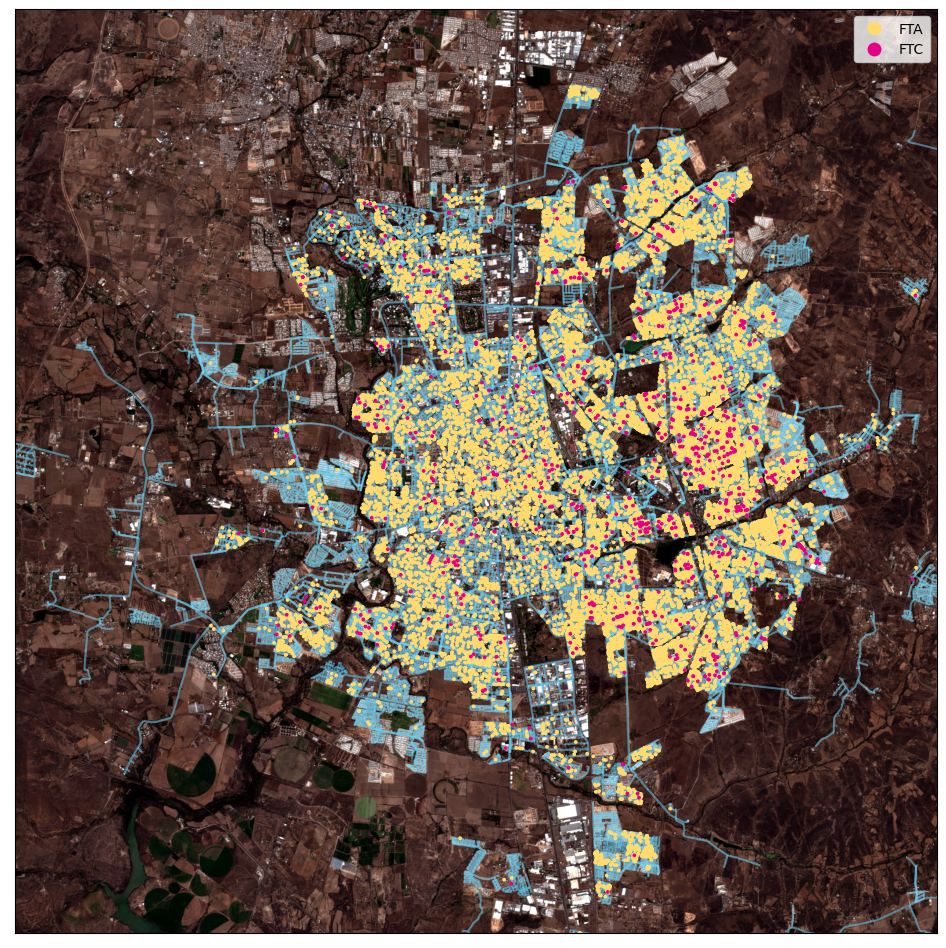

In [234]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot boundary with high zorder for contrast
tuberias.plot(ax = ax, color = "#6FDBFF", alpha = 0.5)
#leaks_gdf.plot(ax = ax, color = "#e60083", markersize = 1, zorder = 2)

# Custom colors                                                 "FTA"       "FTC"
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ffdb6f", "#e60083"])

leaks_gdf.groupby("tipo")

leaks_gdf.plot(ax = ax, column = "tipo", cmap = cmap, markersize = 3, zorder = 2, legend = True)

# Plot CIR image using the raster extent
ep.plot_rgb(
    sat_stack,
    rgb=(2, 1, 0),
    ax=ax,
    extent = extent,
    stretch=True,
    str_clip=0.5,
)

plt.show()


## EDA for collected images

In [11]:
leaks_download = pd.read_csv("../data/clean/leaks_clean_download.csv")
nonleaks_download = pd.read_csv("../data/clean/download_nonleak.csv")

In [32]:
leaks_download = leaks_download.rename(columns = {"sentinel_cloud": "sentinel_cloud_leak", "landsat_cloud": "landsat_cloud_leak", "sentinel_img_date":"sentinel_img_date_leak", "landsat_img_date":"landsat_img_date_leak", "date_diff_img": "date_diff_img_leak", "rmse": "rmse_leak"})
leaks_download.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'fecha_de_i', 'fecha_fina',
       'fechaasign', 'fechalegal', 'nombreunid', 'codestado', 'codtrabajo',
       'actividad', 'barrio', 'com1', 'com2', 'causal', 'orden', 'solicitud',
       'cliente', 'producto', 'consecruta', 'codruta', 'x', 'y', 'id_download',
       'sentinel_img_date_leak', 'landsat_img_date_leak', 'date_diff_img_leak',
       'date_diff_leak', 'sentinel_cloud_leak', 'landsat_cloud_leak',
       'rmse_leak'],
      dtype='object')

In [13]:
nonleaks_download.columns

Index(['Unnamed: 0', 'id', 'id_download_nonleak', 'sentinel_img_date_nonleak',
       'landsat_img_date_nonleak', 'date_diff_img_nonleak',
       'date_diff_leak_nonleak', 'sentinel_cloud_nonleak',
       'landsat_cloud_nonleak', 'rmse_nonleak'],
      dtype='object')

In [33]:
# Merge DFs to plot leak and nonleak info
leaks_clean = pd.merge(leaks_download, nonleaks_download, how = "left", on = "id")
leaks_clean.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'id', 'fecha_de_i', 'fecha_fina',
       'fechaasign', 'fechalegal', 'nombreunid', 'codestado', 'codtrabajo',
       'actividad', 'barrio', 'com1', 'com2', 'causal', 'orden', 'solicitud',
       'cliente', 'producto', 'consecruta', 'codruta', 'x', 'y', 'id_download',
       'sentinel_img_date_leak', 'landsat_img_date_leak', 'date_diff_img_leak',
       'date_diff_leak', 'sentinel_cloud_leak', 'landsat_cloud_leak',
       'rmse_leak', 'Unnamed: 0_y', 'id_download_nonleak',
       'sentinel_img_date_nonleak', 'landsat_img_date_nonleak',
       'date_diff_img_nonleak', 'date_diff_leak_nonleak',
       'sentinel_cloud_nonleak', 'landsat_cloud_nonleak', 'rmse_nonleak'],
      dtype='object')

In [36]:
leaks_clean.nunique()

Unnamed: 0.1                 985
Unnamed: 0_x                 985
id                           981
fecha_de_i                   533
fecha_fina                   531
fechaasign                   496
fechalegal                   499
nombreunid                    26
codestado                      1
codtrabajo                     1
actividad                      1
barrio                       211
com1                         277
com2                         938
causal                         1
orden                        985
solicitud                      2
cliente                      918
producto                     918
consecruta                   278
codruta                      475
x                            918
y                            918
id_download                  981
sentinel_img_date_leak        71
landsat_img_date_leak         71
date_diff_img_leak             5
date_diff_leak                29
sentinel_cloud_leak           71
landsat_cloud_leak            55
rmse_leak 

Text(0, 0.5, 'Frequency')

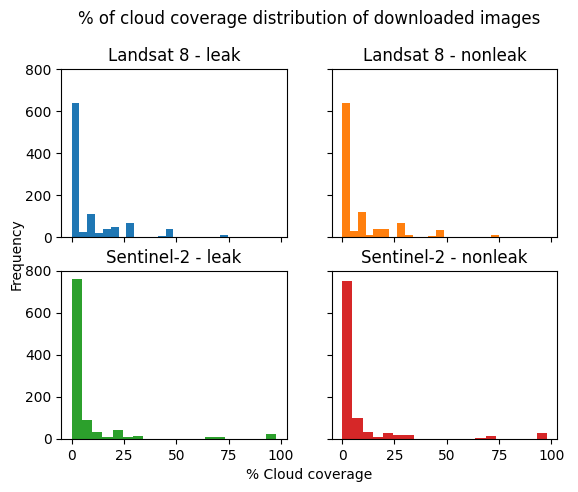

In [168]:
# Group df
cloud_coverage_dist = pd.melt(leaks_clean, id_vars = "id", value_vars = ["sentinel_cloud_leak", "sentinel_cloud_nonleak", "landsat_cloud_leak", "landsat_cloud_nonleak"])

# Replace variable names
cloud_coverage_dist["variable"].replace("landsat_cloud_leak", "Landsat 8 - leak", inplace = True) 
cloud_coverage_dist["variable"].replace("landsat_cloud_nonleak", "Landsat 8 - nonleak", inplace = True) 
cloud_coverage_dist["variable"].replace("sentinel_cloud_leak", "Sentinel-2 - leak", inplace = True) 
cloud_coverage_dist["variable"].replace("sentinel_cloud_nonleak", "Sentinel-2 - nonleak", inplace = True) 

colors = plt.rcParams["axes.prop_cycle"]()
figure, axs = plt.subplots(2, 2, sharex = True, sharey = True)
figure.add_subplot(111, frameon = False)
for group, ax  in zip(cloud_coverage_dist.groupby("variable"), axs.flatten()):
    c = next(colors)["color"]
    ax.hist(group[1].value, color = c, bins = 20)
    ax.title.set_text(group[0])

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) 
plt.title("% of cloud coverage distribution of downloaded images", y = 1.1)
plt.xlabel("% Cloud coverage")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

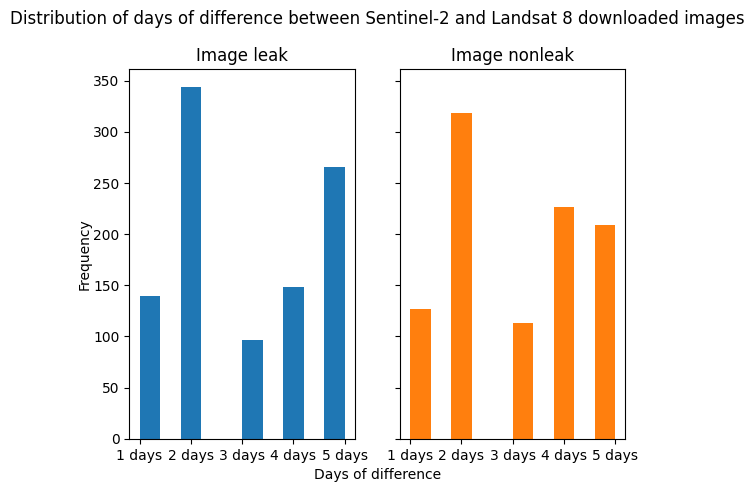

In [132]:
# Group df
date_diff_dist = pd.melt(leaks_clean, id_vars = "id", value_vars = ["date_diff_img_leak", "date_diff_img_nonleak"])

# Replace variable names
date_diff_dist["variable"].replace("date_diff_img_leak", "Image leak", inplace = True) 
date_diff_dist["variable"].replace("date_diff_img_nonleak", "Image nonleak", inplace = True) 

colors = plt.rcParams["axes.prop_cycle"]()
figure, axs = plt.subplots(1, 2, sharex = True, sharey = True)
figure.add_subplot(111, frameon = False)
for group, ax  in zip(date_diff_dist.sort_values(["variable", "value"]).groupby("variable"), axs.flatten()):
    c = next(colors)["color"]
    ax.hist(group[1].value, color = c)
    ax.title.set_text(group[0])

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) 
plt.title("Distribution of days of difference between Sentinel-2 and Landsat 8 downloaded images", y = 1.1)
plt.xlabel("Days of difference")
plt.ylabel("Frequency")

<AxesSubplot: >

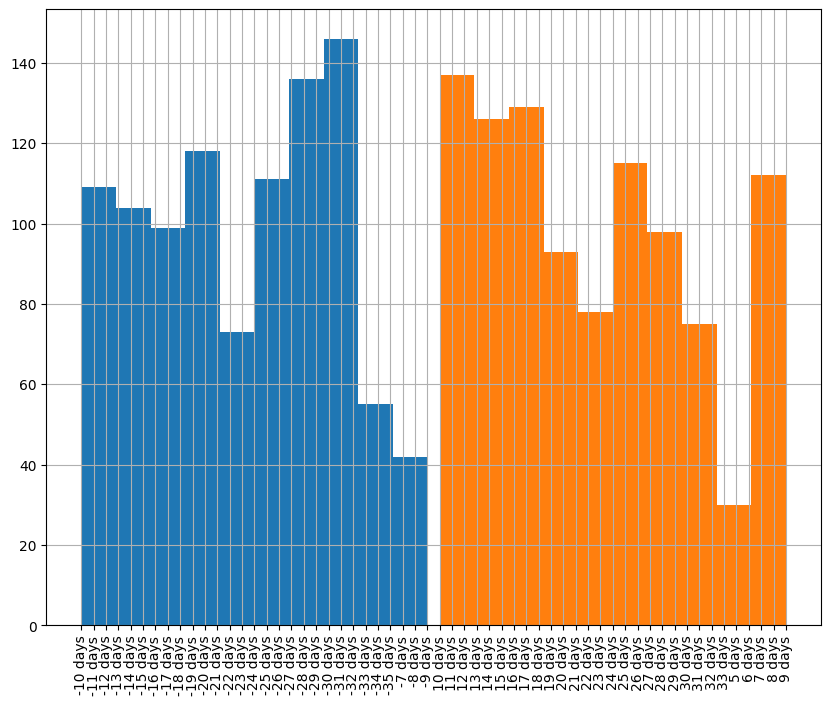

In [28]:
# Plot distribution of days of difference between the collected image and the leak repair
plt.figure(figsize = (10, 8))
leaks_clean.sort_values("date_diff_leak", inplace = False).date_diff_leak.hist(xrot = 90)
leaks_clean.sort_values("date_diff_leak_nonleak", inplace = False).date_diff_leak_nonleak.hist(xrot = 90)

Text(0, 0.5, 'Frequency')

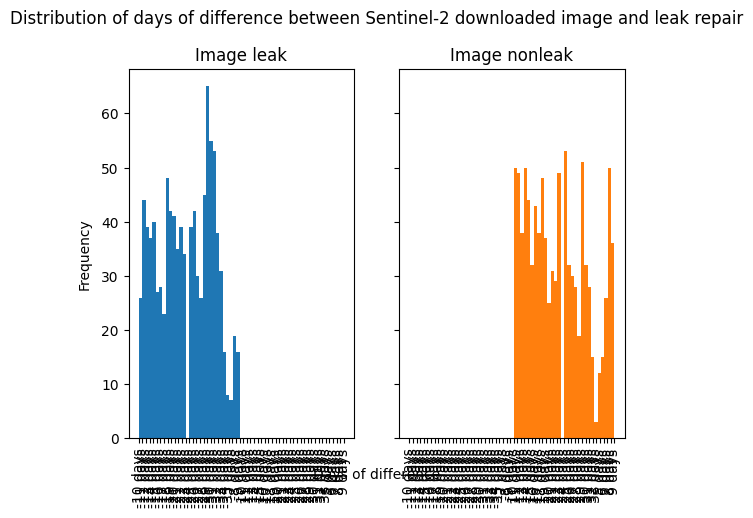

In [165]:
# Group df
date_diff_leak_dist = pd.melt(leaks_clean, id_vars = "id", value_vars = ["date_diff_leak", "date_diff_leak_nonleak"])

# Replace variable names
date_diff_leak_dist["variable"].replace("date_diff_leak", "Image leak", inplace = True) 
date_diff_leak_dist["variable"].replace("date_diff_leak_nonleak", "Image nonleak", inplace = True) 

colors = plt.rcParams["axes.prop_cycle"]()
figure, axs = plt.subplots(1, 2, sharex = True, sharey = True)
figure.add_subplot(111, frameon = False)
for group, ax  in zip(date_diff_leak_dist.sort_values(["variable", "value"]).groupby("variable"), axs.flatten()):
    c = next(colors)["color"]
    ax.hist(group[1].value, color = c, bins = 30)
    ax.title.set_text(group[0])
    ax.tick_params(axis = "x", labelrotation = 90)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) 
plt.title("Distribution of days of difference between Sentinel-2 downloaded image and leak repair", y = 1.1)
plt.xlabel("Days of difference", )
plt.ylabel("Frequency")

Text(0, 0.5, 'Frecuencia')

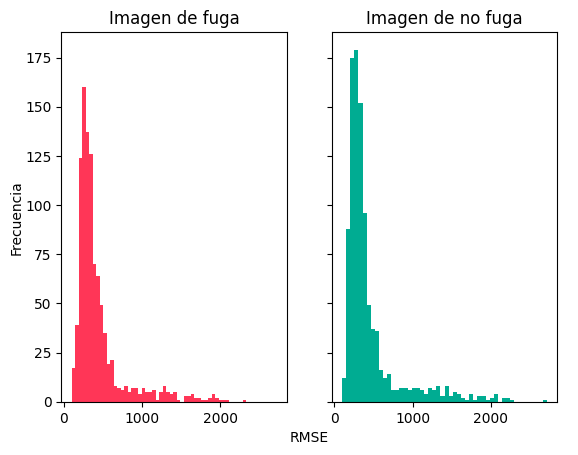

In [256]:
# RMSE

# Group df
RMSE_dist = pd.melt(leaks_clean, id_vars = "id", value_vars = ["rmse_leak", "rmse_nonleak"])

# Replace variable names
RMSE_dist["variable"].replace("rmse_leak", "Imagen de fuga", inplace = True) 
RMSE_dist["variable"].replace("rmse_nonleak", "Imagen de no fuga", inplace = True) 

colors = ["#ff3657", "#00ac92"]
# colors = plt.rcParams["axes.prop_cycle"]()
figure, axs = plt.subplots(1, 2, sharex = True, sharey = True)
figure.add_subplot(111, frameon = False)
for group, ax, c in zip(RMSE_dist.groupby("variable"), axs.flatten(), colors):

    ax.hist(group[1].value, color = c, bins = 50)
    ax.title.set_text(group[0])

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) 
# plt.title("Distribution of RMSE accross all estimated regression models", y = 1.1)
plt.xlabel("RMSE")
plt.ylabel("Frecuencia")

In [173]:
# Descriptive statistics of RMSE dist
RMSE_dist.groupby("variable", as_index = False).agg({"value": ["min", "mean", "max", "std"]})

variable       value                                     
                         min        mean          max         std
0     Image leak  105.105621  443.199654  2331.738797  336.927065
1  Image nonleak   99.504319  453.290938  2715.228523  379.086102

In [231]:
# Get summary statistics of LST for all tiff files

# Get path of all images
leak_images_paths = glob("../data/patches_clean/leak/*leak*")
nonleak_images_paths = glob("../data/patches_clean/non_leak/*nonleak*")

# Read every image and get LST values

# First leak images
lst_leaks_min = []
lst_leaks_mean = []
lst_leaks_max = []

for image in leak_images_paths:
    lst_values = imread(image)[:, :, 13]
    lst_leaks_min.append(lst_values.min())
    lst_leaks_mean.append(lst_values.mean())
    lst_leaks_max.append(lst_values.max())

# Now nonleak images
lst_nonleaks_min = []
lst_nonleaks_mean = []
lst_nonleaks_max = []

for image in leak_images_paths:
    lst_values = imread(image)[:, :, 13]
    lst_nonleaks_min.append(lst_values.min())
    lst_nonleaks_mean.append(lst_values.mean())
    lst_nonleaks_max.append(lst_values.max())

# Create df 
lst_df = pd.DataFrame({"type_img": ["leak" if i < 983 else "nonleak" for i in range(0, len(leak_images_paths + nonleak_images_paths) - 1)],
                       "lst_min": lst_leaks_min + lst_nonleaks_min,
                       "lst_mean": lst_leaks_mean + lst_nonleaks_mean,
                       "lst_max": lst_leaks_max + lst_nonleaks_max})

In [255]:
lst_df.melt(id_vars = "type_img", value_vars = ["lst_min", "lst_mean", "lst_max"]).groupby(["type_img", "variable"], as_index = False).agg({"value": ["min", "mean", "max", "std"]})

type_img  variable         value                                         
                               min          mean           max          std
0     leak   lst_max  33674.099877  50148.875941  73457.405832  4432.976852
1     leak  lst_mean  31555.112094  47265.555781  53827.736798  2848.878030
2     leak   lst_min      0.000000  43606.195581  50184.092152  5339.927854
3  nonleak   lst_max  33674.099877  50137.125924  73457.405832  4436.132214
4  nonleak  lst_mean  31555.112094  47259.027150  53827.736798  2849.663206
5  nonleak   lst_min      0.000000  43606.515742  50184.092152  5334.503065

Text(0, 0.5, 'Frequency')

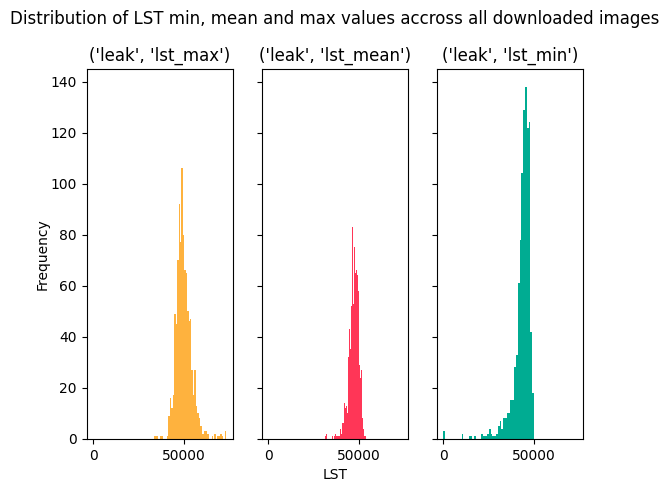

In [254]:
# Plot distribution of LST
lst_df_long = lst_df.melt(id_vars = "type_img", value_vars = ["lst_min", "lst_mean", "lst_max"], )

colors = ["#feb23e", "#ff3657", "#00ac92", ""]
# colors = plt.rcParams["axes.prop_cycle"]()
figure, axs = plt.subplots(1, 3, sharex = True, sharey = True)
figure.add_subplot(111, frameon = False)
for group, ax, c in zip(lst_df_long.groupby(["type_img", "variable"]), axs.flatten(), colors):

    ax.hist(group[1].value, color = c, bins = 50)
    ax.title.set_text(group[0])

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) 
plt.title("Distribution of LST min, mean and max values accross all downloaded images", y = 1.1)
plt.xlabel("LST")
plt.ylabel("Frequency")

## Display sample images

In [3]:
#ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [4]:
# Get image from image collection
def get_image(start, end, poi_leak):
    
    if isinstance(start, str) == False:
        start = str(start)
        end = str(end)
    
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
    .filterBounds(poi_leak)\
    .filterDate(ee.Date(start), ee.Date(end))\
    .sort("system:time_start", opt_ascending = False)\
    .sort("CLOUDY_PIXEL_PERCENTAGE")

    img = collection.first()

    print("Date of selected image (Sentinel): ", ee.Date(img.get("system:time_start")).format("yyyy-MM-dd").getInfo(),
          "\nSentinel images found:", collection.size().getInfo(),
          "\nCloud %: ", img.get("CLOUDY_PIXEL_PERCENTAGE").getInfo()) 
    
    return img  

In [5]:
# Define the bands to select and the patch size (radius in meters respect to leak point)
def bands_clip_image(image, poi, buffer_size = 100, bands = ["B4", "B3", "B2"]):
    # Clip image
    image = image.clip(poi.buffer(buffer_size).bounds(proj = "EPSG:32613", maxError = 0.001))

    # Select bands
    image = image.select(bands)

    return image

In [6]:
# Download patch image
def download_image(image, path, date_label):
    url = image.getDownloadURL(
        {
        "scale": 10,
        "crs": "EPSG:32613",
        "fileFormat": "GeoTIFF",
        "maxPixels": 1e13
        }
    )

    r = requests.get(url, allow_redirects = True)
    open(path + "S2" + "_" + date_label + ".zip", "wb").write(r.content)
    print("Download complete")

In [7]:
def get_landsat_images(start, end, poi_leak):

    if isinstance(start, str) == False:
        start = str(start)
        end = str(end)

    selected_Landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")\
                                    .filterBounds(poi_leak)\
                                    .filterDate(ee.Date(start), ee.Date(end))\
                                    .sort("CLOUD_COVER")

    img_landsat = selected_Landsat_collection.first()

    print("Date of selected image (Landsat):", ee.Date(img_landsat.get("system:time_start")).format("yyyy-MM-dd").getInfo(),
        "\nLandsat images found: ", selected_Landsat_collection.size().getInfo(),
        "\nCloud %: ", img_landsat.get("CLOUD_COVER").getInfo())
    
    if selected_Landsat_collection.size().getInfo() == 0:
        print("THERES NO LANDSAT IMAGES FOR THE SELECTED DATES")

    return img_landsat

In [23]:
# Info of leak 
end_date = leaks.fechalegal[0]
start_date = end_date - datetime.timedelta(days = 15)
lon = leaks["X"][0]
lat = leaks["Y"][0]
transformer = pyproj.Transformer.from_crs("epsg:32613", "epsg:4326")
leak_lon, leak_lat = transformer.transform(lon, lat)
poi_leak = ee.Geometry.Point([leak_lat, leak_lon])

In [24]:
s2_sample = get_image(start = start_date, end = end_date, poi_leak = poi_leak)
l8_sample = get_landsat_images(start = start_date, end = end_date, poi_leak = poi_leak)

Date of selected image (Sentinel):  2020-01-03 
Sentinel images found: 7 
Cloud %:  0.055907
Date of selected image (Landsat): 2020-01-05 
Landsat images found:  2 
Cloud %:  1.89


In [67]:
s2_sample_clip = bands_clip_image(s2_sample, poi = poi_leak, buffer_size = 1000)
l8_sample_clip = bands_clip_image(l8_sample, poi = poi_leak, buffer_size = 1000, bands = ["SR_B4", "SR_B3", "SR_B2"])

In [68]:
# Download images

# Sentinel
download_image(s2_sample_clip, "../data/images/", date_label = "s2_sample")

# Landsat
download_image(l8_sample_clip, "../data/images/", date_label = "l8_sample") 

Download complete
Download complete


In [69]:
import os
import zipfile

# Get names of all the zips
zips_dirs = ["S2_s2_sample.zip", "S2_l8_sample.zip"]

# Remove .zip extension from the name
patch_dir_names = ["S2_s2_sample", "S2_l8_sample"]

parent_dir = "../data/images/"

for dir, patch_dir in zip(zips_dirs, patch_dir_names):
    path_zip = os.path.join(parent_dir, dir)
    if zipfile.is_zipfile(path_zip):
        with zipfile.ZipFile(path_zip) as item:
            item.extractall(os.path.join(parent_dir, patch_dir))

In [70]:
# Stack bands
s2_bands = glob("../data/images/S2_s2_sample/*B*.tif")
l8_bands = glob("../data/images/S2_l8_sample/*B*.tif")

def my_digit_sort(my_list):
   return list(map(int, re.findall(r'(?<=.B)\d+(?=A?.tif)', my_list)))[0]

s2_bands.sort(key = my_digit_sort)
l8_bands.sort(key = my_digit_sort)


In [72]:
s2_stacked = []
for patch in s2_bands:
    with rio.open(patch, "r") as f:
        s2_stacked.append(f.read(1))
        print(f.profile)

l8_stacked = []
for patch in l8_bands:
    with rio.open(patch, "r") as f:
        l8_stacked.append(f.read(1))
        print(f.profile)

# stack bands into an nd array
s2_stacked = np.transpose(np.stack(s2_stacked))
s2_stacked.shape

l8_stacked = np.transpose(np.stack(l8_stacked))
l8_stacked.shape

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 200, 'height': 201, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 781110.0,
       0.0, -10.0, 2424440.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 200, 'height': 201, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 781110.0,
       0.0, -10.0, 2424440.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 200, 'height': 201, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 781110.0,
       0.0, -10.0, 2424440.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 200, 'height': 201, 'count': 1, 'crs': CRS.from_epsg(32

(200, 201, 3)

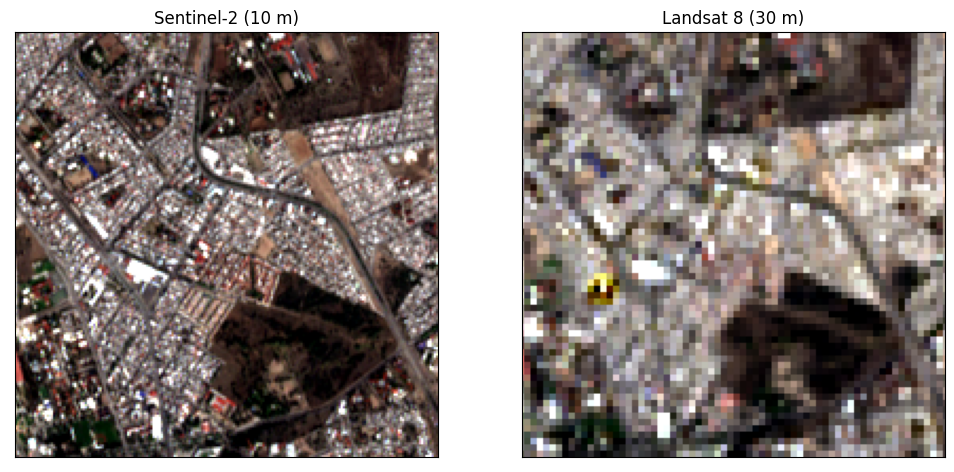

In [77]:
# Create figure with one plot
label_dicc = {"Sentinel-2 (10 m)":0,
              "Landsat 8 (30 m)":1}
images = [s2_stacked, l8_stacked]
Y = [0, 1]

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 12))

for i, ax in zip(range(0, 2), axs.ravel()):
    ep.plot_rgb(np.transpose(images[i]), 
                rgb = (2, 1, 0),
                stretch = True,
                ax = ax)

    title_lab = [lab for lab in label_dicc if label_dicc[lab] == Y[i]][0]
    ax.set_title(title_lab)
plt.show()

## EDA for tiff files

In [8]:
# Get a sample of tiff bands
patches_bands = glob("../data/patches_raw/leak/S2_i20445d_2020-01-28_12/*B*.tif")

def my_digit_sort(my_list):
   return list(map(int, re.findall(r'(?<=.B)\d+(?=A?.tif)', my_list)))[0]

patches_bands.sort(key = my_digit_sort)
patches_bands.append(glob("../data/patches_raw/leak/S2_i20445d_2020-01-28_12/*WVP*.tif")[0])
patches_bands.append(glob("../data/patches_raw/leak/S2_i20445d_2020-01-28_12/*LST*.tif")[0])
patches_bands

['../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B1.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B2.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B3.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B4.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B5.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B6.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B7.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B8.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B8A.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QG

In [9]:
# Get each band name
titles = [re.search(r"(?<=T13QGE.)(.*)(?=.tif)", band).group() for band in patches_bands]
titles

# Get path of images
leak_images_paths = glob("../data/patches_clean/leak/*leak*")
nonleak_images_paths = glob("../data/patches_clean/non_leak/*nonleak*")

In [10]:
# Function to order paths by their id
def my_path_sort(my_list):
   return list(map(int, re.findall(r'(?<=leak)\d+(?=_idLeak)', my_list)))[0]

In [11]:
# Sort paths
leak_images_paths.sort(key = my_path_sort)
nonleak_images_paths.sort(key = my_path_sort)

### Functions to plot multiple bands, lst and nmdi

In [12]:
# Read image
def read_tif(img):
    return imread(img)

In [13]:
# Plot all Sentinel Bands
def norm_bands(tif):
    return (tif - tif.min())/(tif.max() - tif.min())

def plot_bands(leak_tif_path, nonleak_tif_path):
    leak_tif = norm_bands(imread(leak_tif_path))
    nonleak_tif = norm_bands(imread(nonleak_tif_path))

    print("leak")
    ep.plot_bands(
        arr = np.transpose(leak_tif[:, :, :13]), cmap = "terrain",
        figsize = (22, 10), cols = 13,
        cbar = True, title = titles[:13],
        vmin = 0, vmax = leak_tif[:, :, :13].max()
    )

    print("nonleak")
    ep.plot_bands(
        arr = np.transpose(nonleak_tif[:, :, :13]), cmap = "terrain",
        figsize = (22, 10), cols = 13,
        cbar = True, title = titles[:13],
        vmin = 0, vmax = nonleak_tif[:, :, :13].max()
    )

    plt.show()

In [14]:
# Land Surface Temperature
def plot_lst(leak_tif_path, nonleak_tif_path):
    leak_tif = norm_bands(imread(leak_tif_path))
    nonleak_tif = norm_bands(imread(nonleak_tif_path))
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    fig.colorbar(plt.imshow(leak_tif[:,:,13], cmap = "gnuplot"))
    plt.title("leak")
    
    fig.add_subplot(1, 2, 2)
    fig.colorbar(plt.imshow(nonleak_tif[:,:,13], cmap = "gnuplot"))
    
    plt.title("no leak")

In [15]:
def plot_ndmi(leak_tif_path, nonleak_tif_path):
    leak_tif = imread(leak_tif_path)
    nonleak_tif = imread(nonleak_tif_path)

    moisture_leak = es.normalized_diff(leak_tif[:, :, 7], leak_tif[:, :, 11])
    moisture_nonleak = es.normalized_diff(nonleak_tif[:, :, 7], nonleak_tif[:, :, 11])
    
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    fig.colorbar(plt.imshow(moisture_leak, cmap = "RdYlGn"))
    plt.title("leak")
    
    fig.add_subplot(1, 2, 2)
    fig.colorbar(plt.imshow(moisture_nonleak, cmap = "RdYlGn"))
    
    plt.title("no leak")

### Multiple bands sample plots

leak


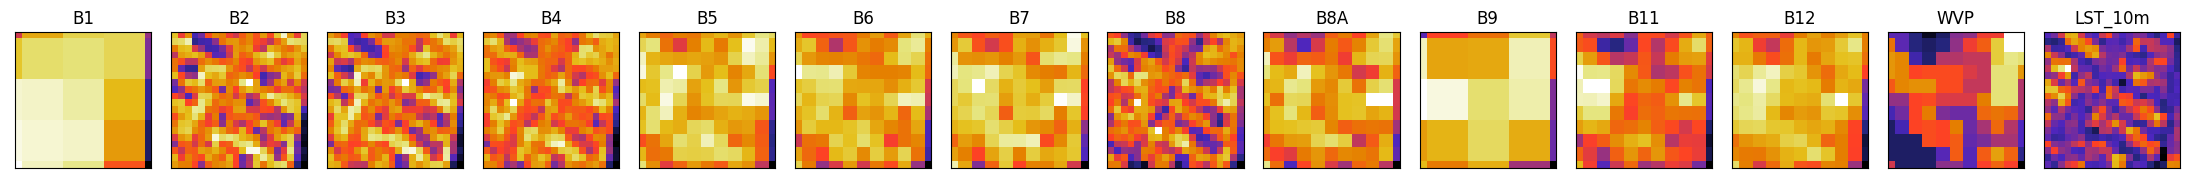

nonleak


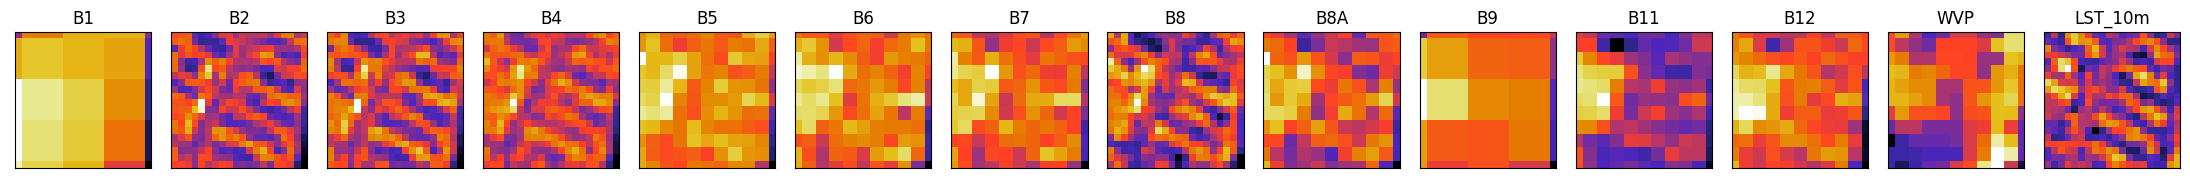

In [58]:
# Plot only one image

leak_tif = imread(leak_images_paths[0])
nonleak_tif = imread(nonleak_images_paths[0])

print("leak")
ep.plot_bands(
    arr = np.transpose(leak_tif), cmap = "CMRmap",
    figsize = (22, 10), cols = 14,
    cbar = False, title = titles
)

print("nonleak")
ep.plot_bands(
    arr = np.transpose(nonleak_tif), cmap = "CMRmap",
    figsize = (22, 10), cols = 14,
    cbar = False, title = titles
)

plt.show()


leak


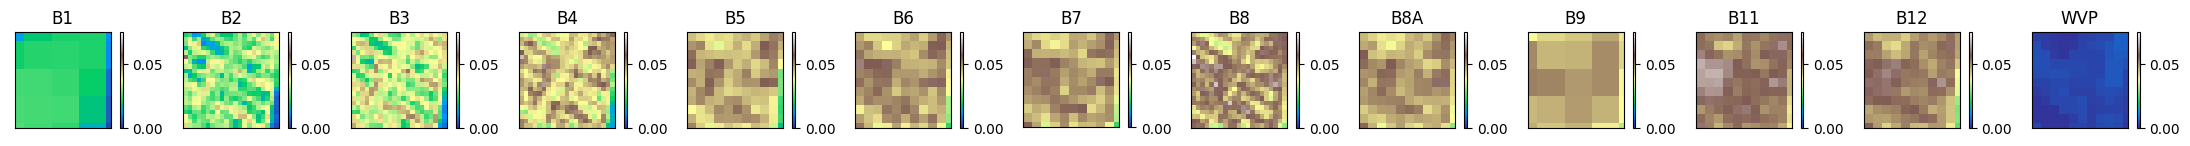

nonleak


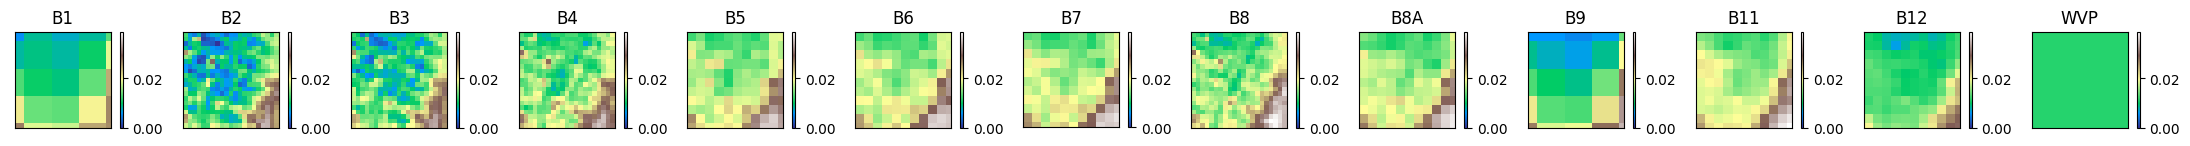

leak


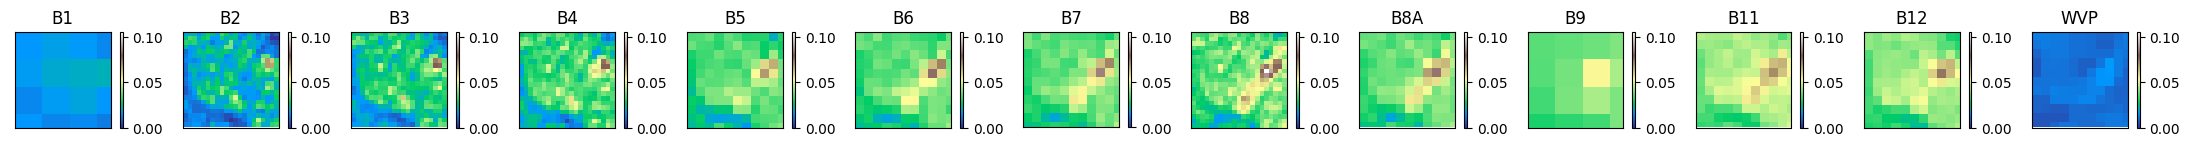

nonleak


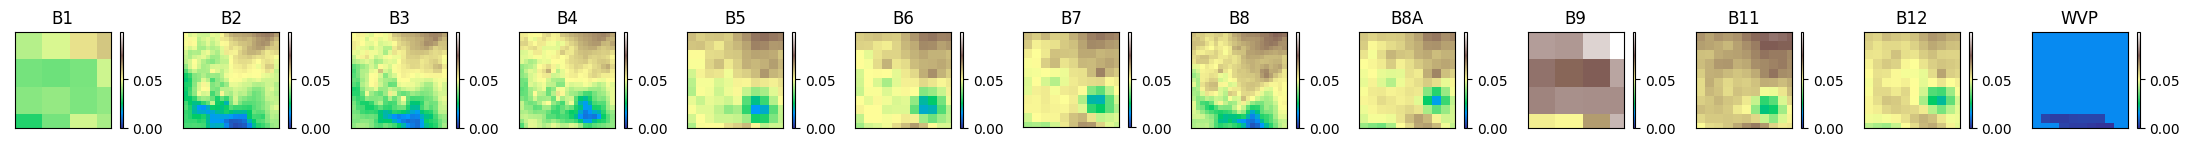

leak


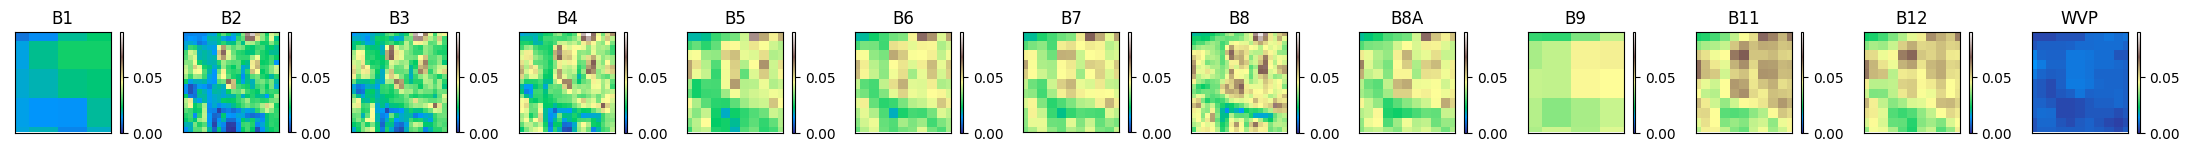

nonleak


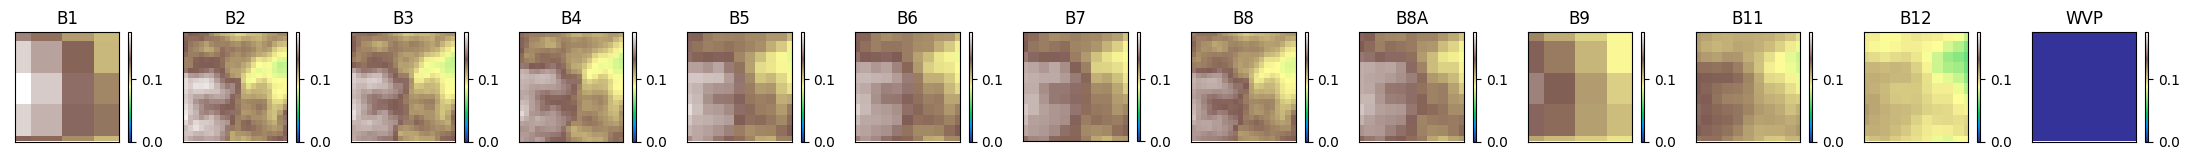

leak


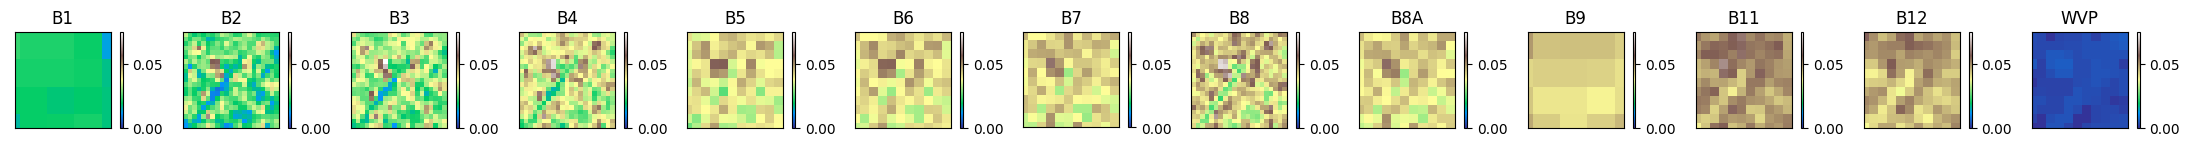

nonleak


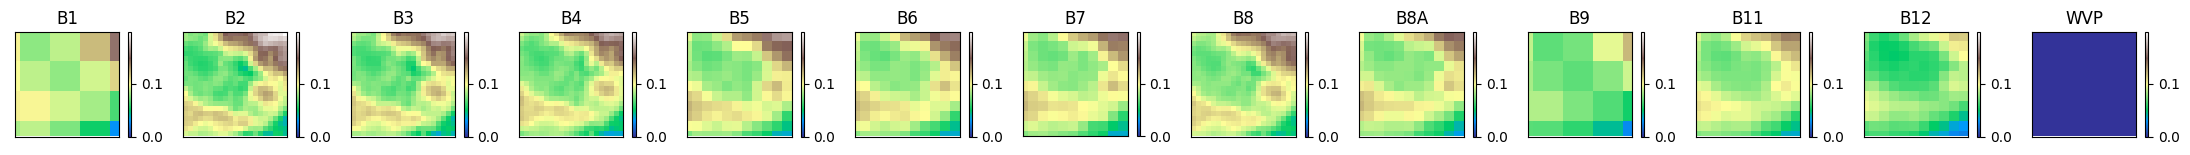

leak


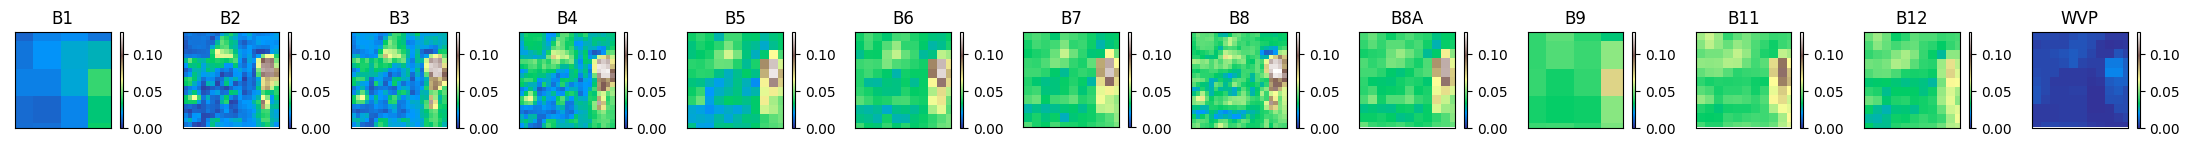

nonleak


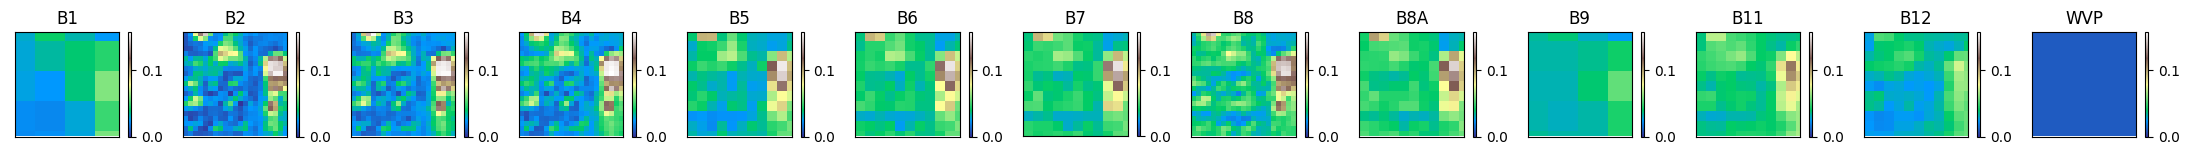

leak


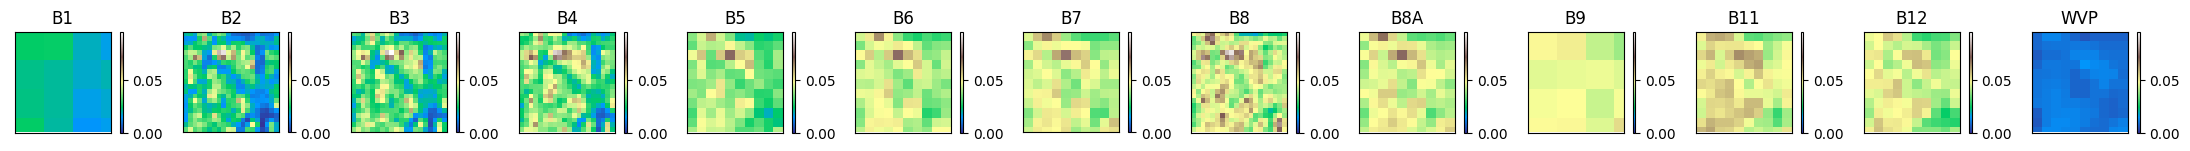

nonleak


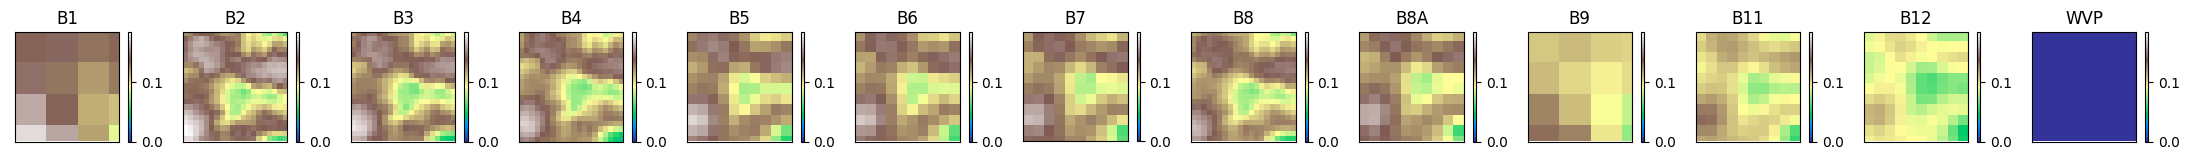

leak


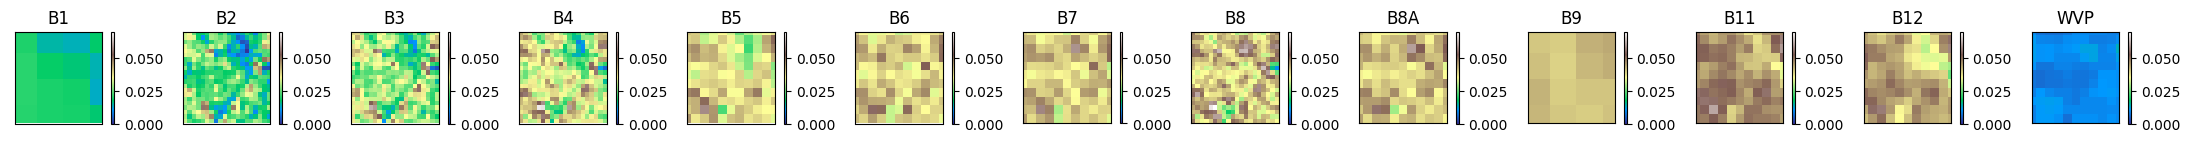

nonleak


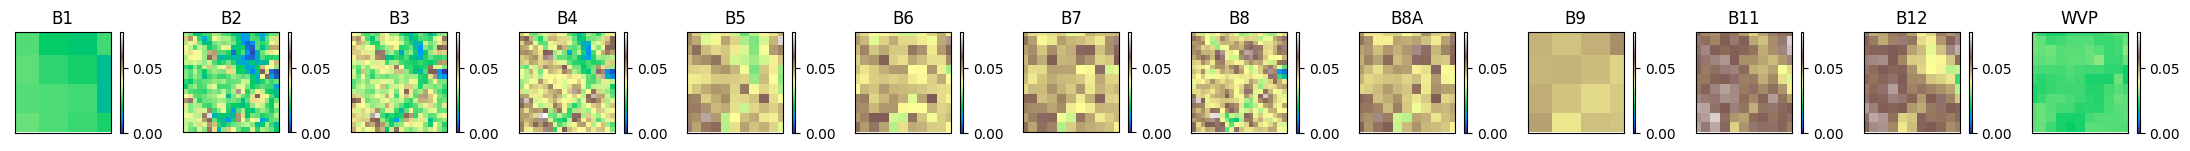

leak


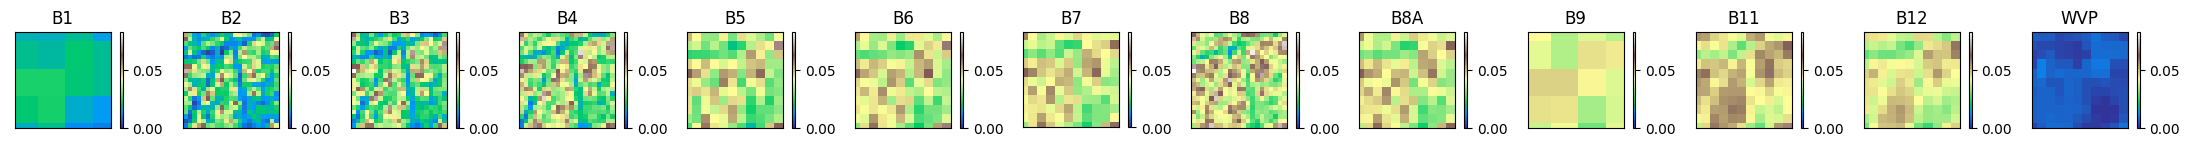

nonleak


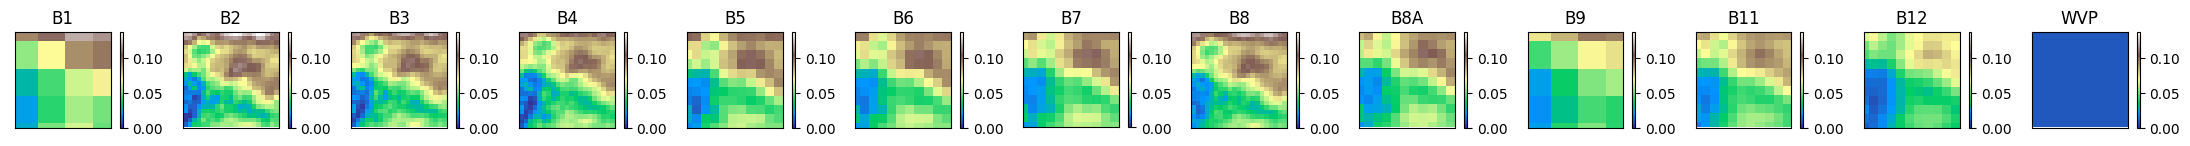

leak


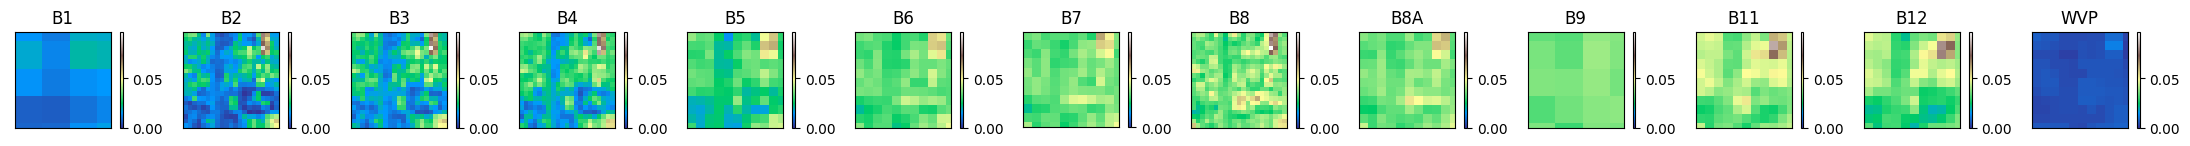

nonleak


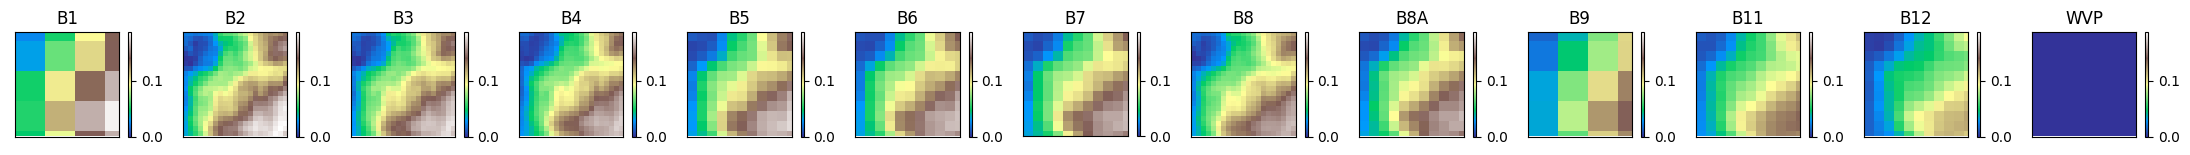

leak


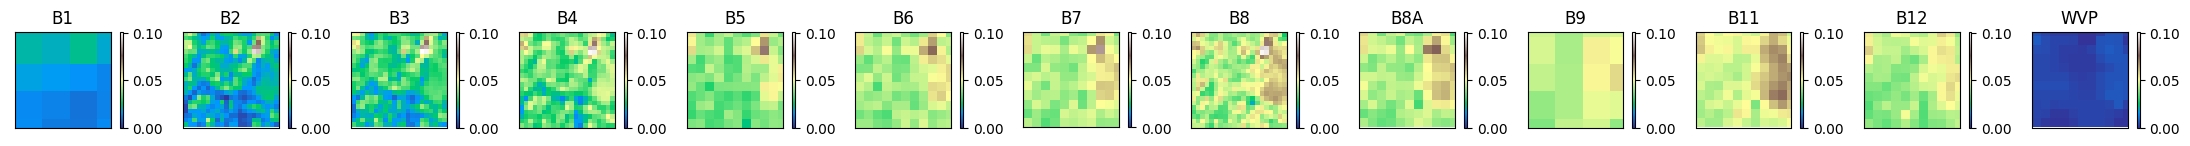

nonleak


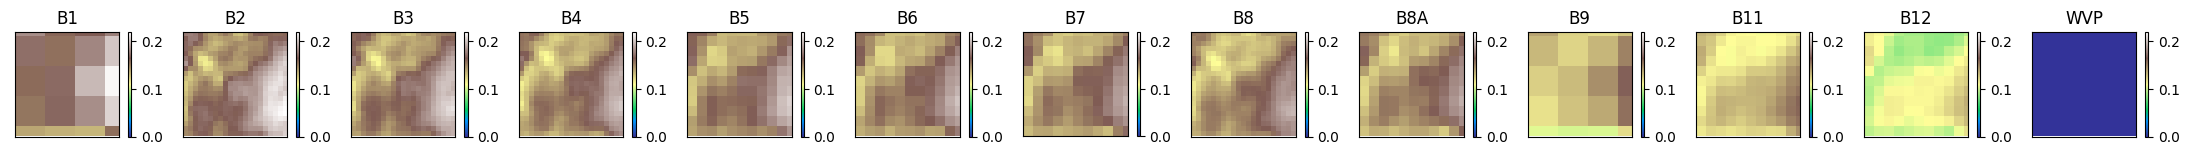

In [17]:
for i in range(0, 10):
    plot_bands(leak_images_paths[i], nonleak_images_paths[i])

### Land Surface Temperature plots

C:\Users\Erick\AppData\Local\Temp\ipykernel_26708\52511358.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


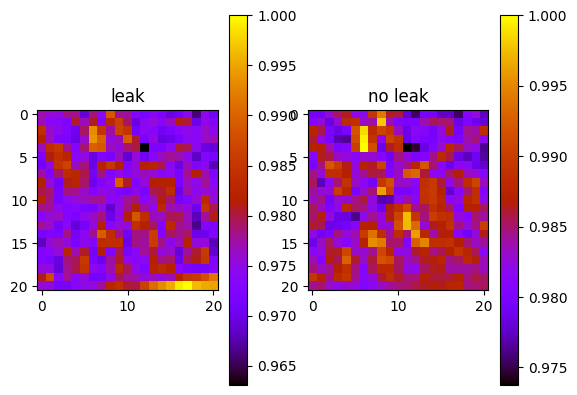

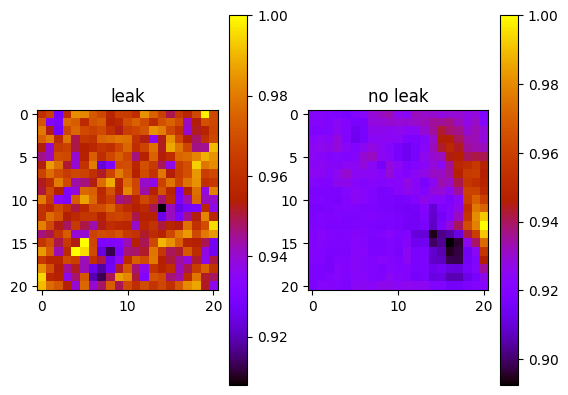

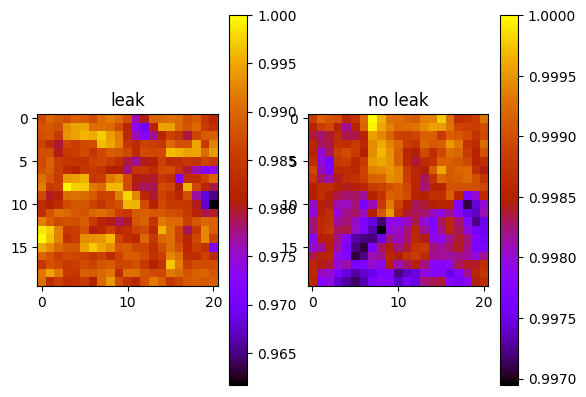

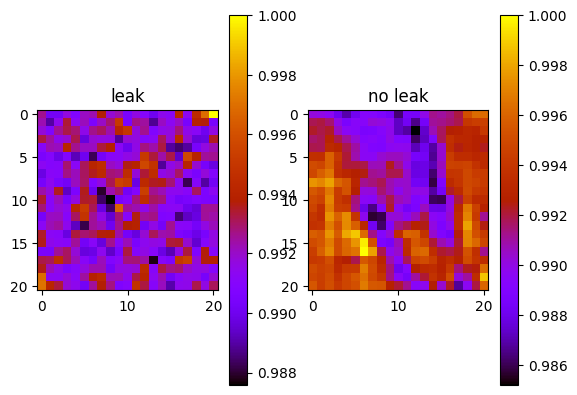

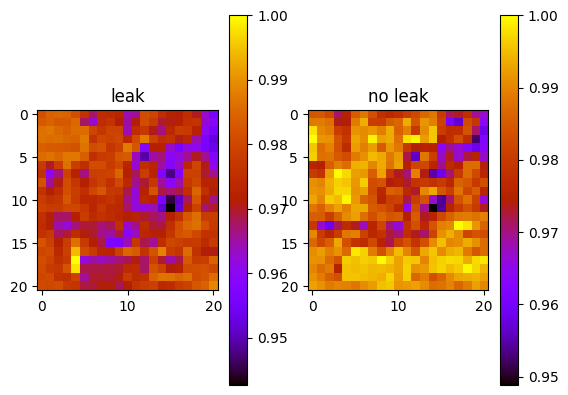

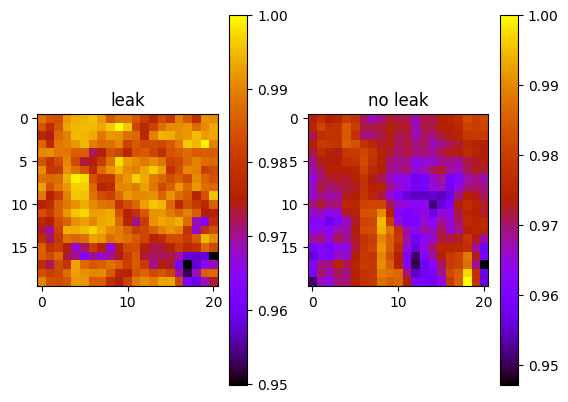

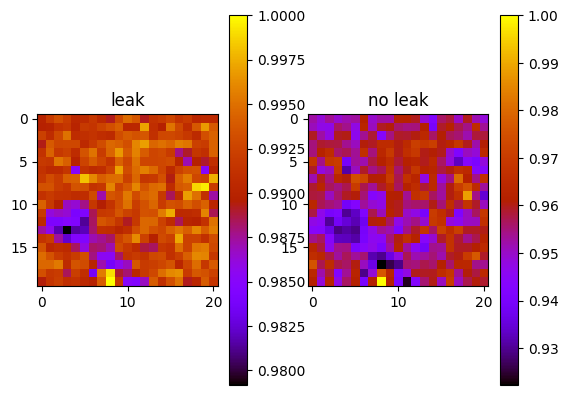

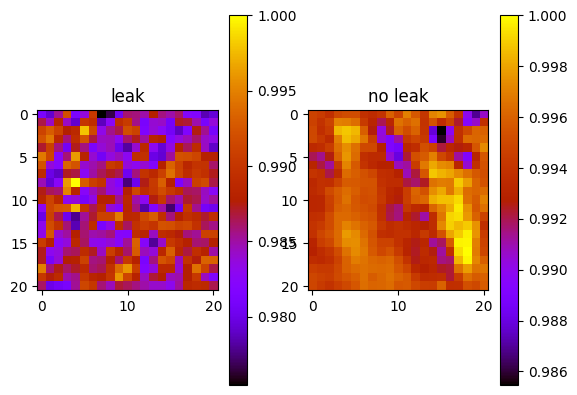

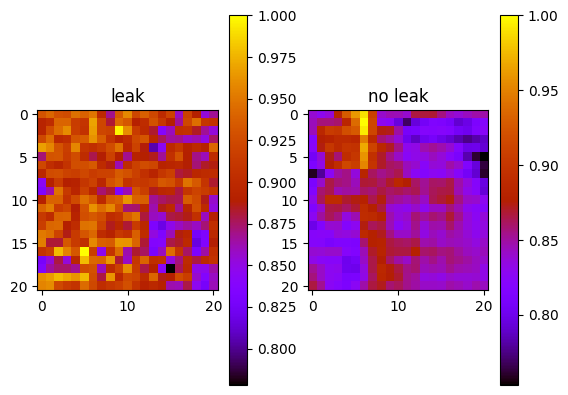

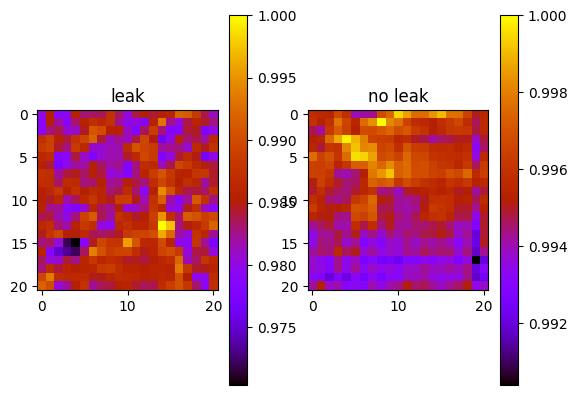

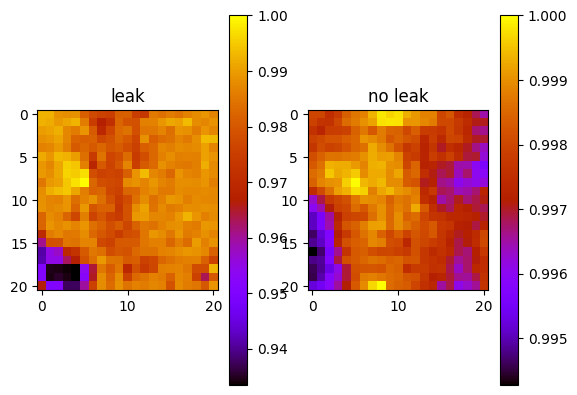

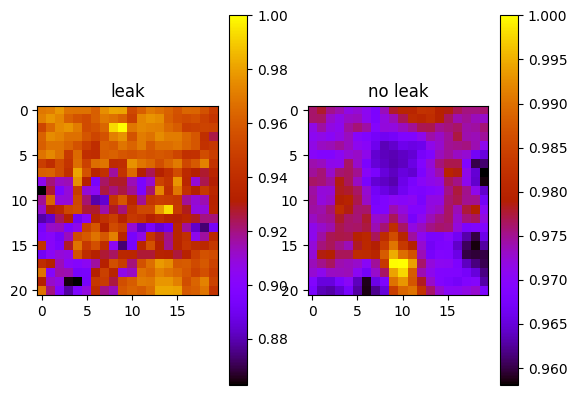

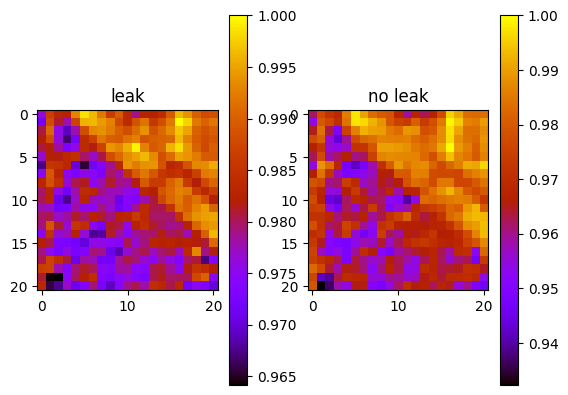

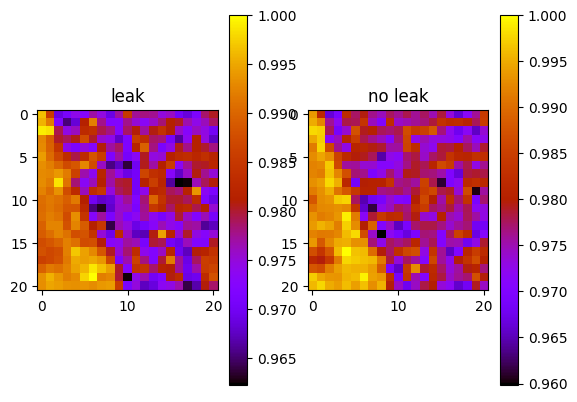

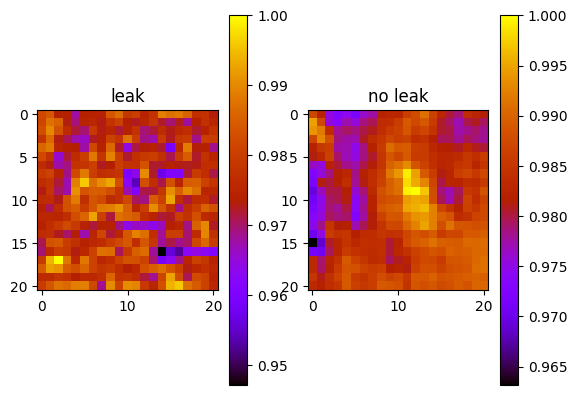

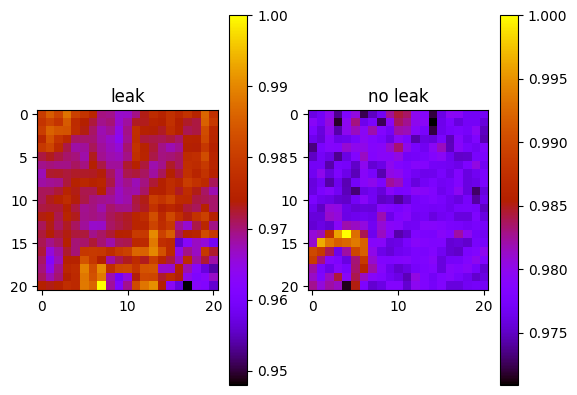

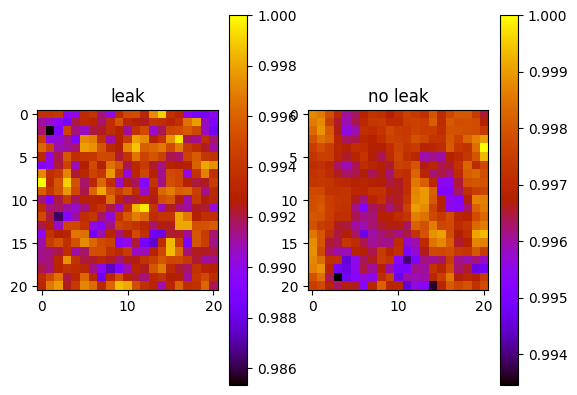

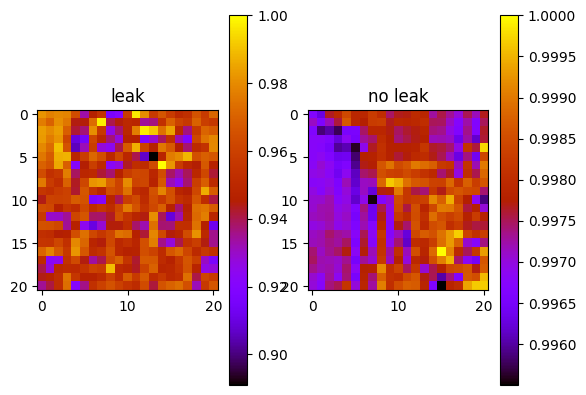

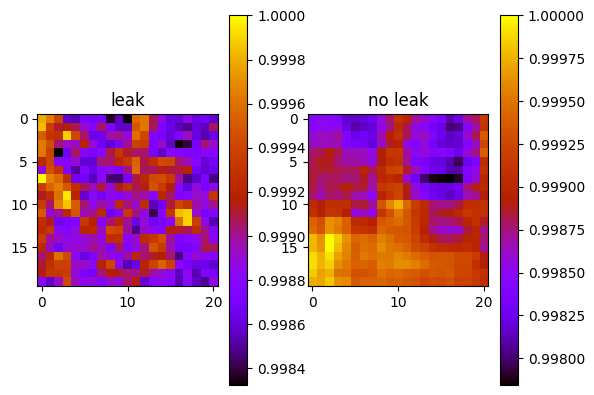

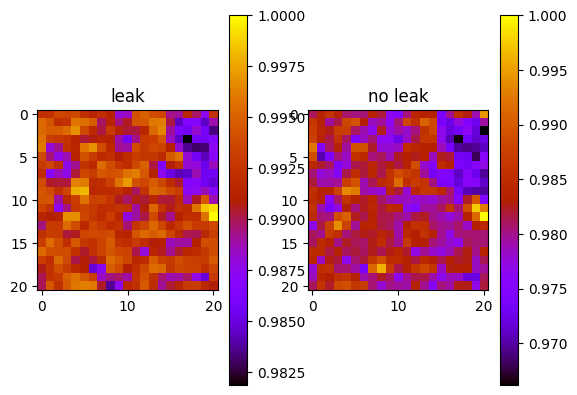

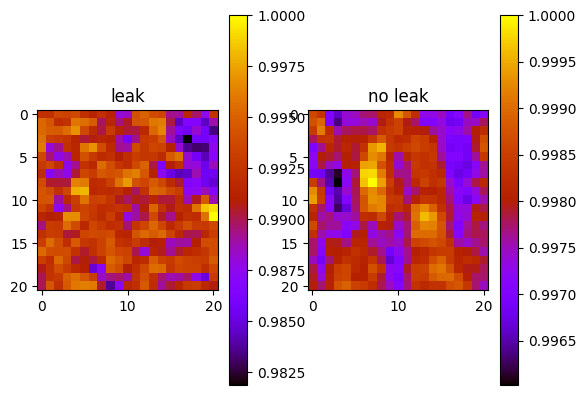

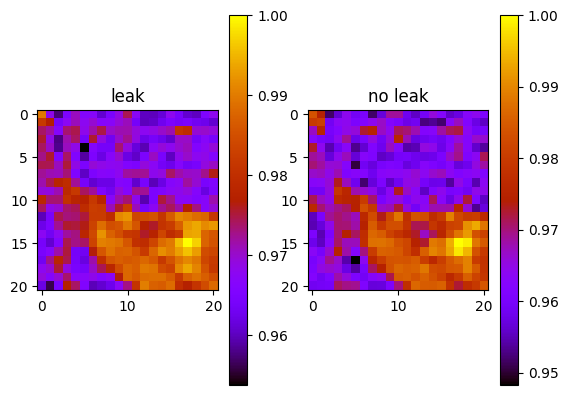

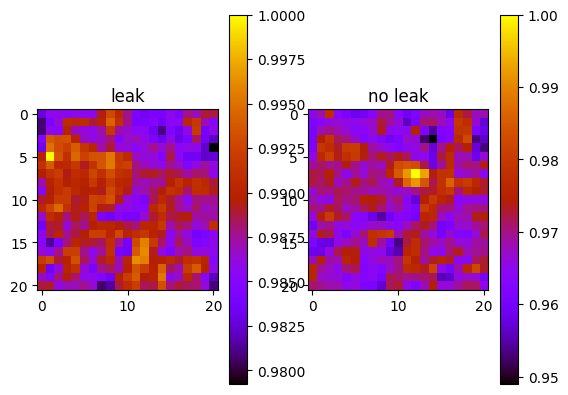

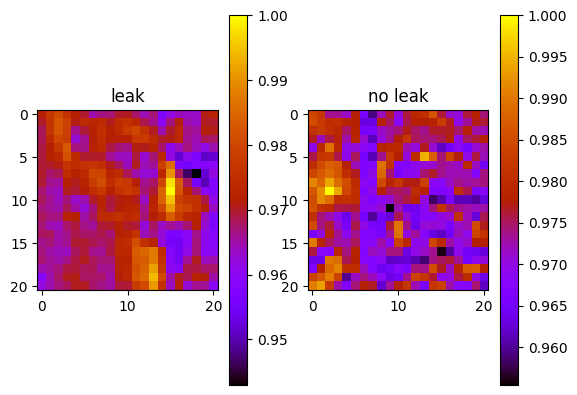

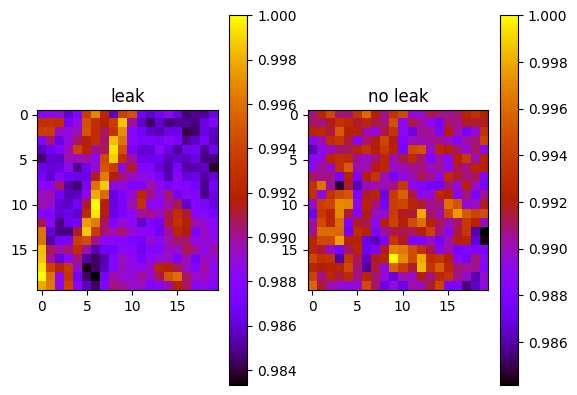

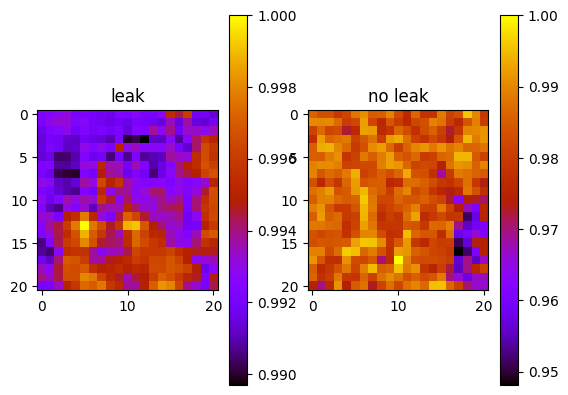

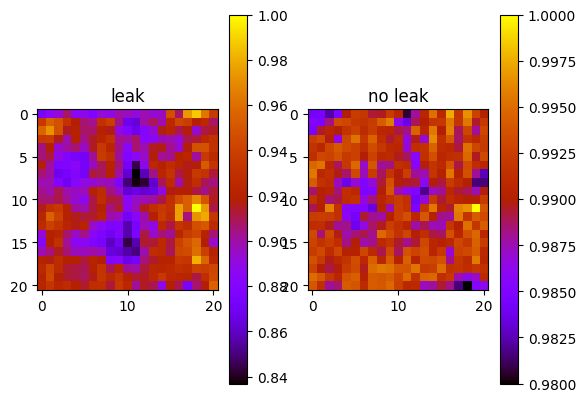

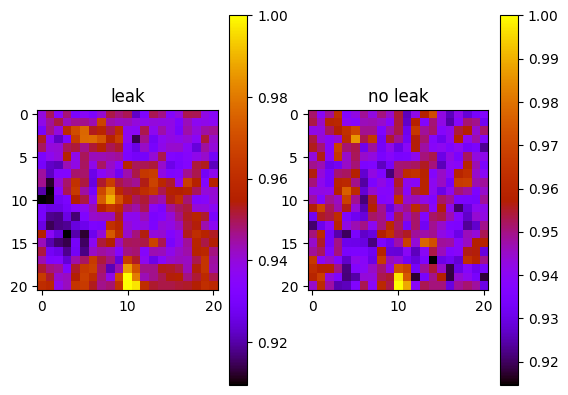

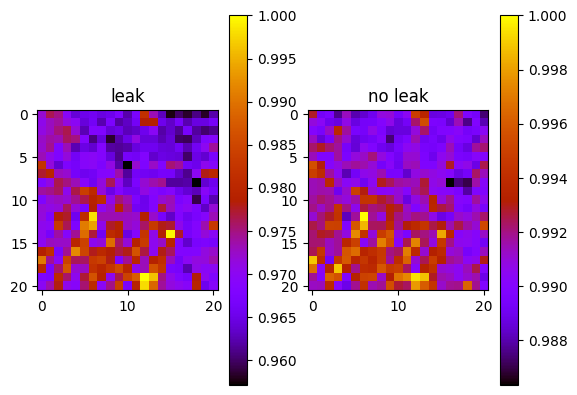

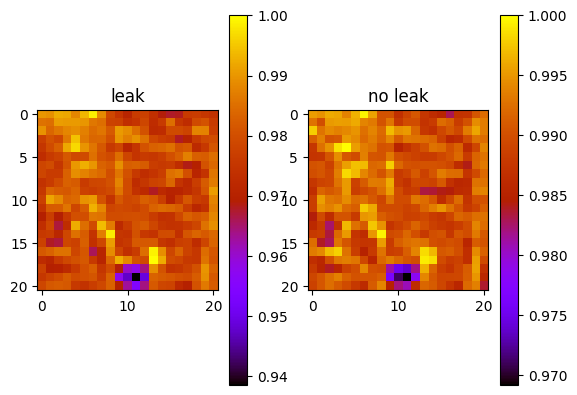

In [10]:
for i in range(0, 30):
    plot_lst(leak_images_paths[i], nonleak_images_paths[i])

### Histograms pixel per band

<Figure size 1200x100 with 0 Axes>

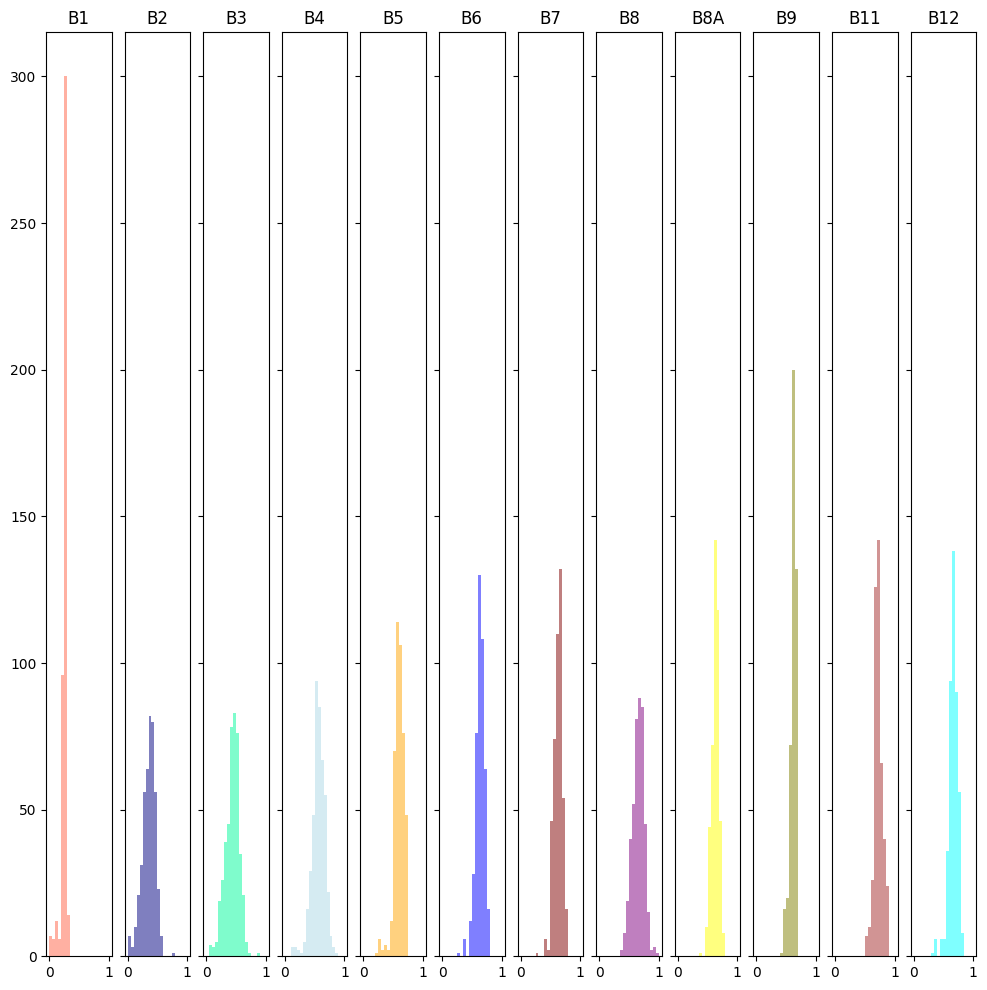

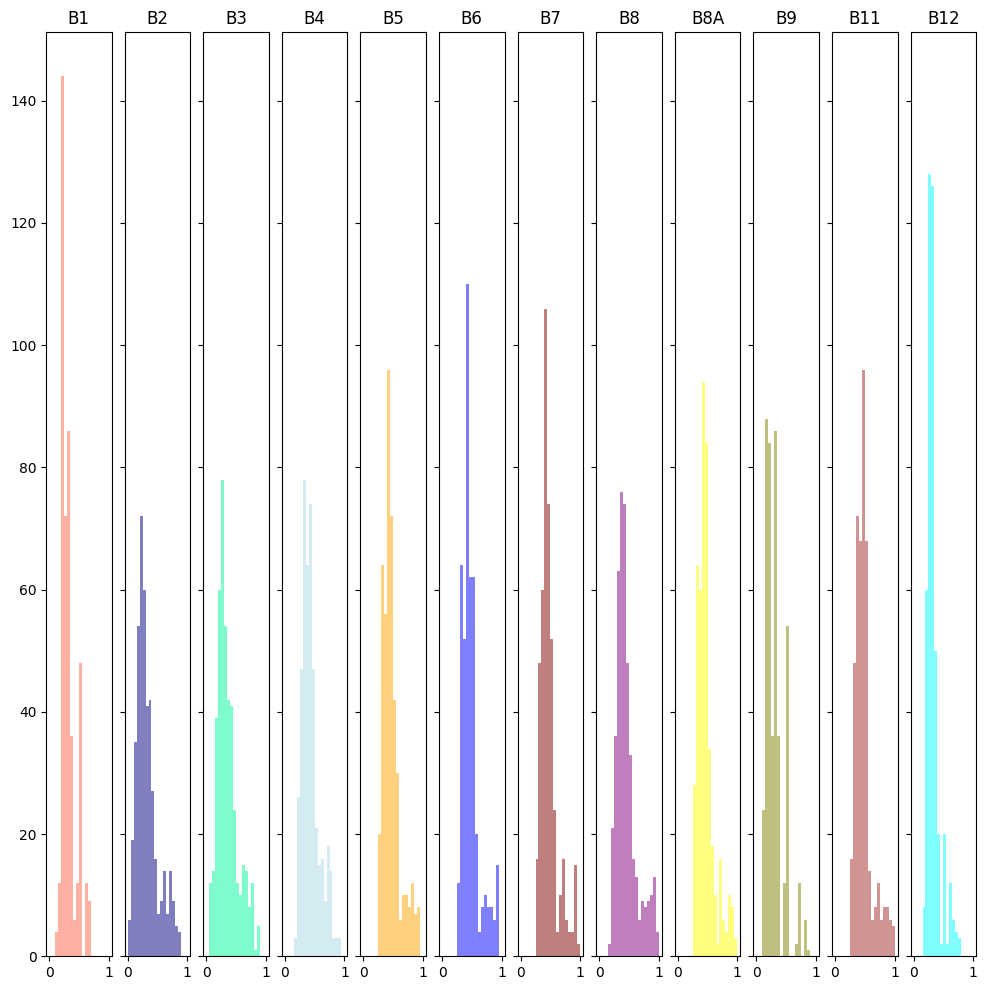

In [21]:
# histogram of pixels per band
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange',
        'blue', 'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', "black", "red"]

fig = plt.figure(figsize = (12,1))

image_leak = read_tif(leak_images_paths[0])
image_nonleak = read_tif(nonleak_images_paths[0])

ep.hist(
    arr = norm_bands(np.transpose(image_leak[:, :, :12])), colors = colors,
    title = titles[:12], cols = 12,
    alpha = 0.5
)

ep.hist(
    arr = norm_bands(np.transpose(image_nonleak[:, :, :12])), colors = colors,
    title = titles[:12], cols = 12,
    alpha = 0.5
)

plt.show()

### Normalized Difference Moisture Index plots

$NDMI = (NIR - SWIR)/(NIR + SWIR) = (B08 - B11)/(B08 + B11)$

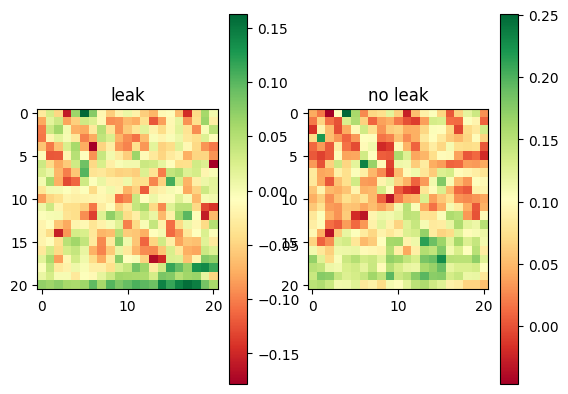

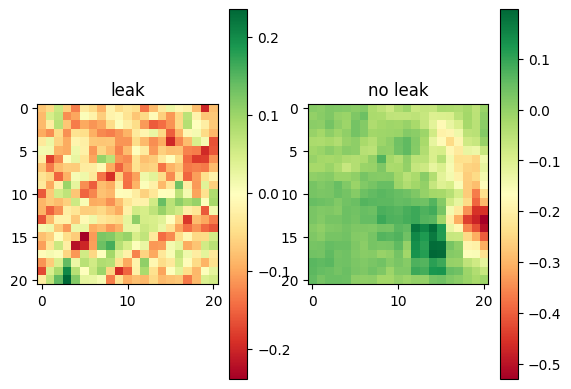

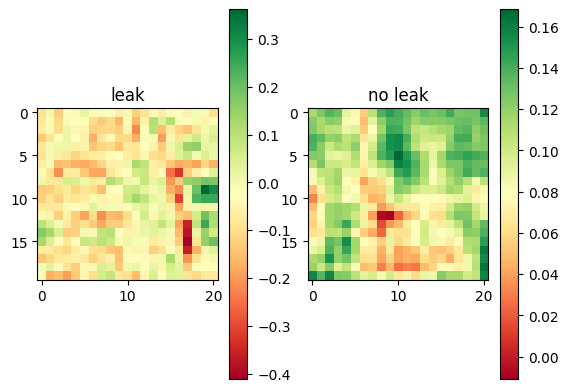

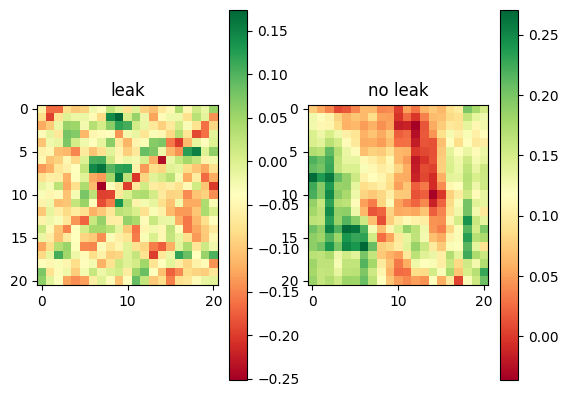

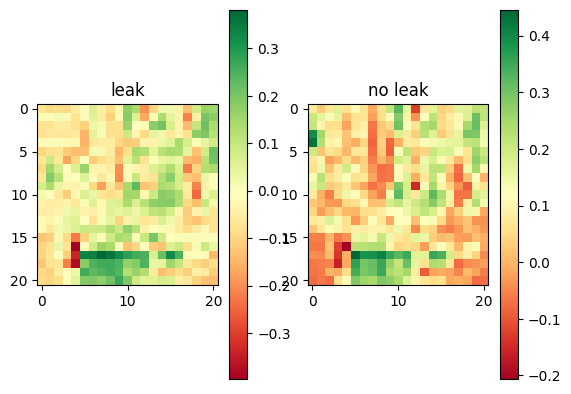

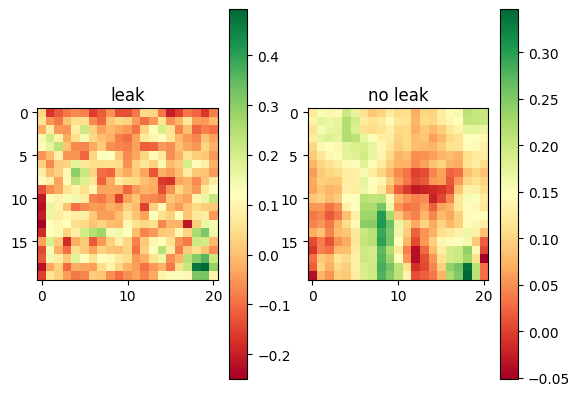

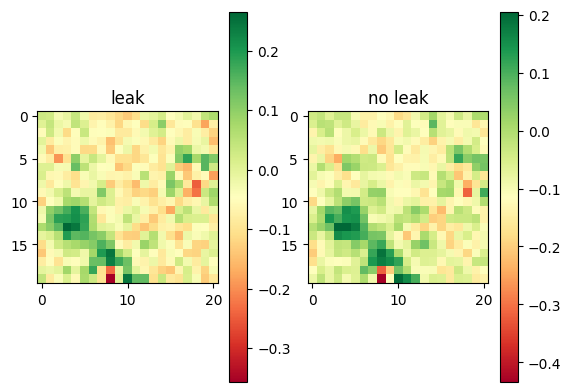

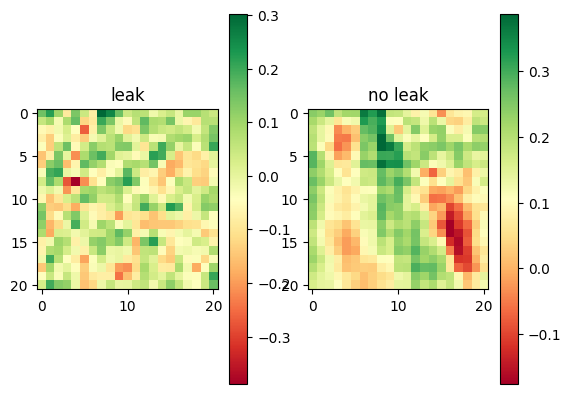

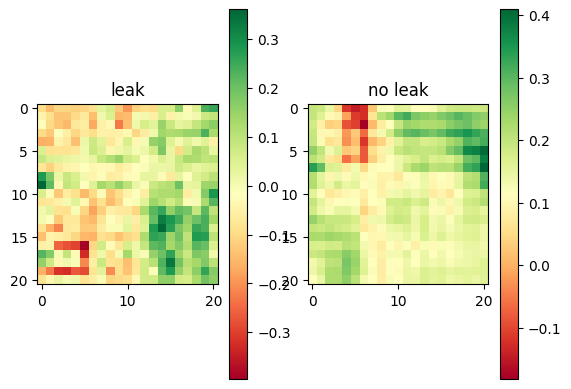

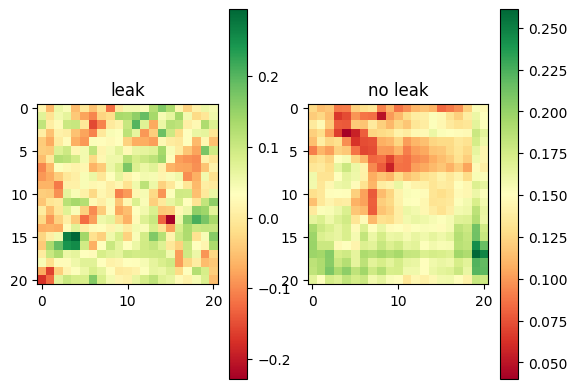

In [11]:
for i in range(0, 10):
    plot_ndmi(leak_tif_path = leak_images_paths[i], nonleak_tif_path = nonleak_images_paths[i])

## EDA for model performance

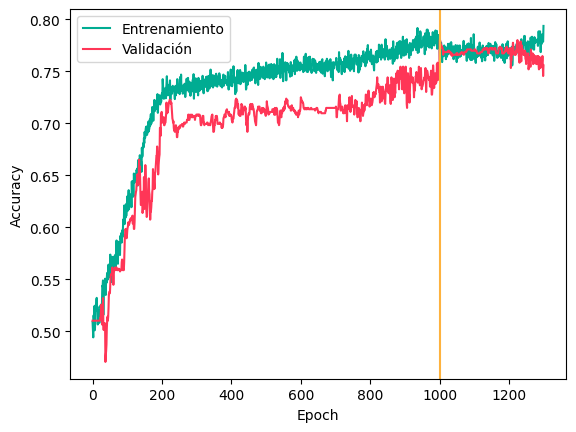

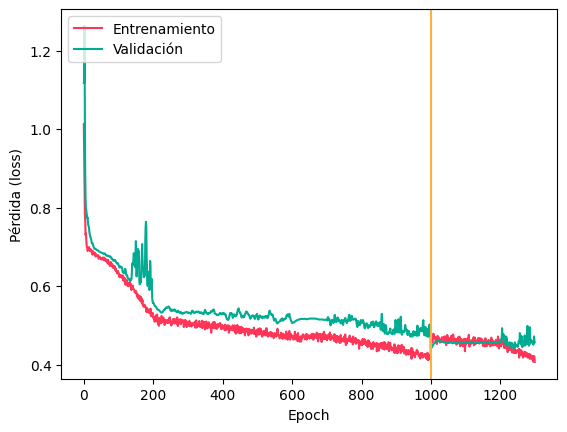

In [74]:
# Final model with LST

# Load history from base model
with open("../models/model_81acc_history", "rb") as file_pi:
    base_model_history = pickle.load(file_pi)

# summarize base_model for accuracy
plt.plot(base_model_history['acc'], color = "#00ac92")
plt.plot(base_model_history['val_acc'], color = "#ff3657")
plt.axvline(x = 1000, color = "#feb23e")
#plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
# summarize base_model for loss
plt.plot(base_model_history['loss'], color = "#ff3657")
plt.plot(base_model_history['val_loss'], color = "#00ac92")
plt.axvline(x = 1000, color = "#feb23e")
#plt.title('model loss')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

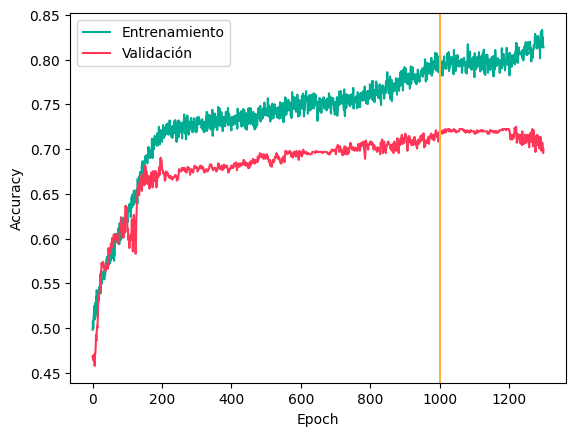

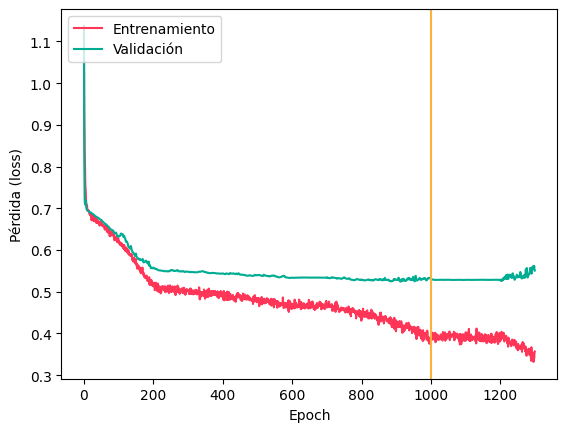

In [73]:
# Final model without LST

# Load history from base model
with open("../models/model_noLST_74acc_history", "rb") as file_pi:
    base_model_history = pickle.load(file_pi)

# summarize base_model for accuracy
plt.plot(base_model_history['acc'], color = "#00ac92")
plt.plot(base_model_history['val_acc'], color = "#ff3657")
plt.axvline(x = 1000, color = "#feb23e")
#plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
# summarize base_model for loss
plt.plot(base_model_history['loss'], color = "#ff3657")
plt.plot(base_model_history['val_loss'], color = "#00ac92")
plt.axvline(x = 1000, color = "#feb23e")
#plt.title('model loss')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()